In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from prophet import Prophet

d:\Project\Project\Intern_Intelligence\Time-Series-Forecasting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [6]:
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(data_url, parse_dates=['Month'], index_col='Month')
print(data.head())

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


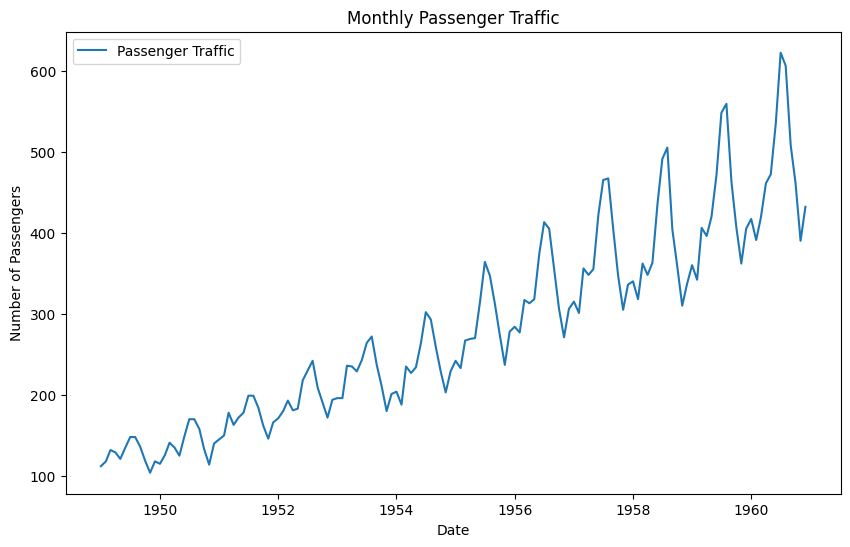

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data, label='Passenger Traffic')
plt.title('Monthly Passenger Traffic')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

## Pre-Processing and Stationarity Check  
- Time series models like ARIMA often require the data to be stationary.    
- We’ll perform an Augmented Dickey-Fuller (ADF) test to check for stationarity and difference the data if necessary.

In [7]:
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] > 0.05:
        print("Data is non-stationary.")
    else:
        print("Data is stationary.")

print("Original Data Stationarity Check:")
check_stationarity(data['Passengers'])

Original Data Stationarity Check:
ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641
Data is non-stationary.


In [8]:
data_diff = data.diff().dropna()
print("\nDifferenced Data Stationarity Check:")
check_stationarity(data_diff['Passengers'])


Differenced Data Stationarity Check:
ADF Statistic: -2.8292668241699994
p-value: 0.0542132902838255
Data is non-stationary.


## ARIMA Model Forecasting  
- ARIMA model, forecast future values, and evaluate the model performance using MAE and RMSE.


In [9]:
model_arima = ARIMA(data['Passengers'], order=(5, 1, 0))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -689.067
Date:                Wed, 19 Mar 2025   AIC                           1390.135
Time:                        11:18:23   BIC                           1407.912
Sample:                    01-01-1949   HQIC                          1397.358
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3223      0.097      3.334      0.001       0.133       0.512
ar.L2         -0.2170      0.078     -2.776      0.006      -0.370      -0.064
ar.L3         -0.0646      0.071     -0.915      0.3

d:\Project\Project\Intern_Intelligence\Time-Series-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Project\Project\Intern_Intelligence\Time-Series-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\Project\Project\Intern_Intelligence\Time-Series-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [10]:
forecast_steps = 12  # forecast next 12 months
forecast_arima = model_fit.forecast(steps=forecast_steps)

# Evaluate Model (if you have actual values for the forecast period, here we assume the last 12 points as test)
actual = data['Passengers'][-forecast_steps:]
mae = mean_absolute_error(actual, forecast_arima)
rmse = sqrt(mean_squared_error(actual, forecast_arima))
print(f"ARIMA MAE: {mae:.2f}")
print(f"ARIMA RMSE: {rmse:.2f}")

ARIMA MAE: 74.60
ARIMA RMSE: 86.32


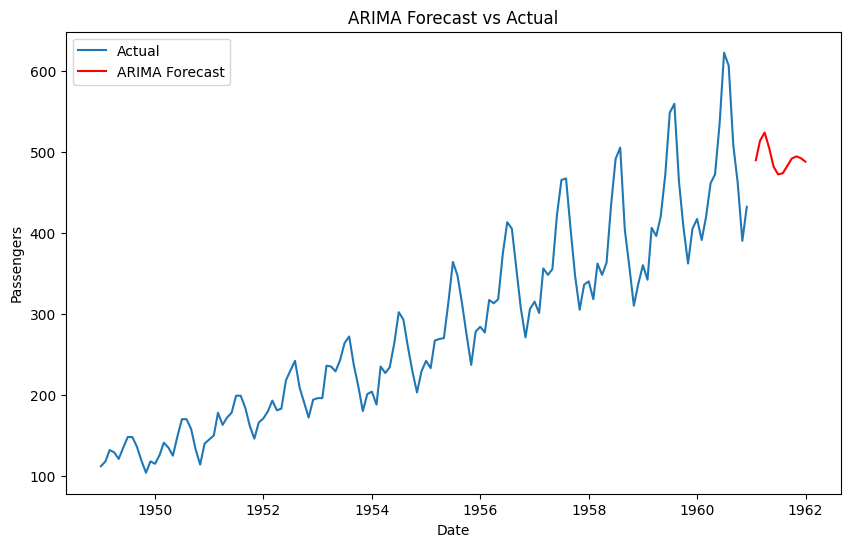

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Passengers'], label='Actual')
# Create a date range for forecasted values
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='ME')[1:]
plt.plot(forecast_index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## Prophet Model Forecasting  
- Prophet requires data with columns named ds (date) and y (value)
- Need to reformat the dataset, train Prophet, and then visualize the forecast.

In [13]:
df_prophet = data.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})
print(df_prophet.head())

          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121


In [14]:
m = Prophet()
m.fit(df_prophet)

11:20:12 - cmdstanpy - INFO - Chain [1] start processing
11:20:13 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = m.make_future_dataframe(periods=12, freq='ME')
forecast_prophet = m.predict(future)

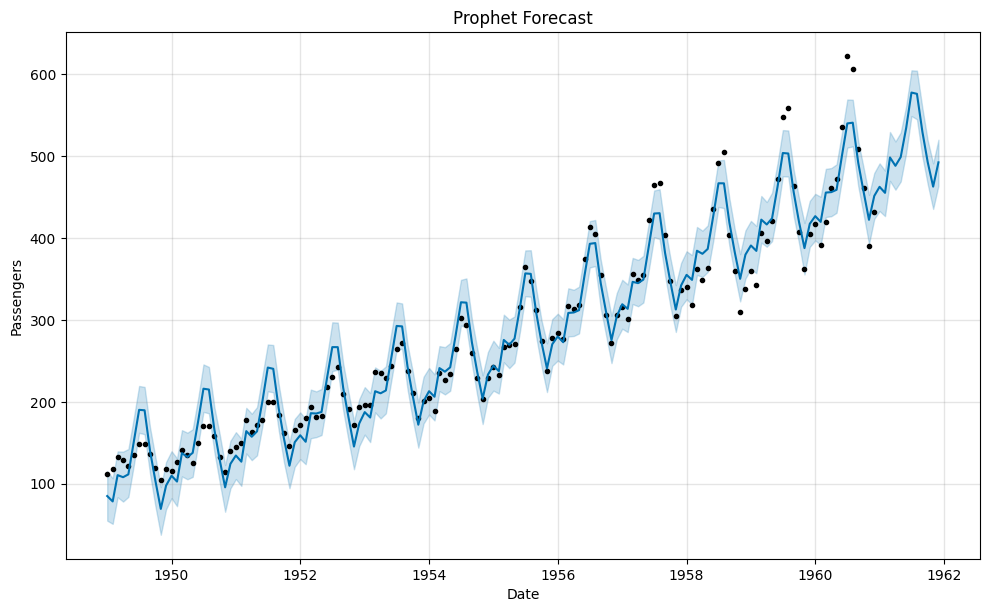

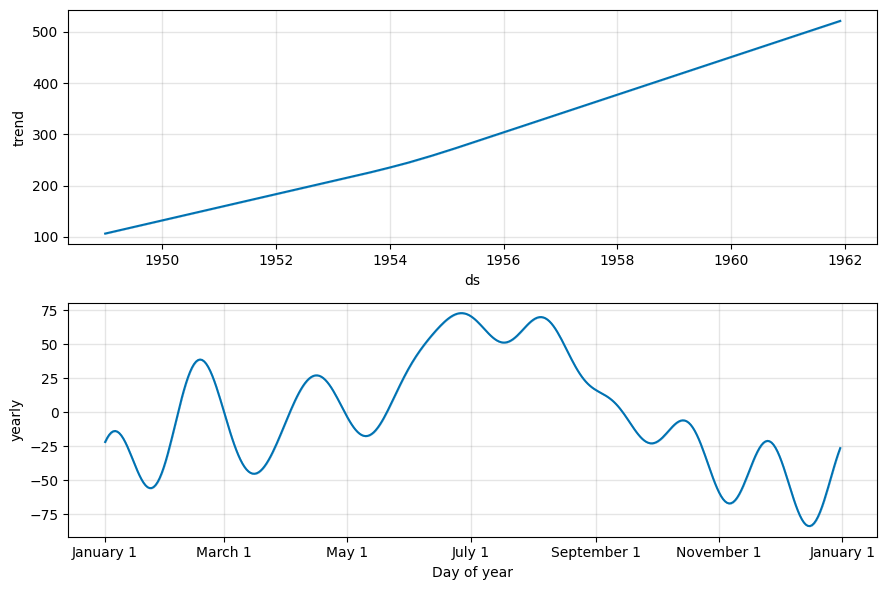

In [17]:
fig1 = m.plot(forecast_prophet)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.show()
fig2 = m.plot_components(forecast_prophet)
plt.show()